In [1]:
!pip uninstall torch torchvision torchdata torchtext -y
!pip install torch==1.13.0 torchvision==0.14.0 torchaudio==0.13.0

#import torch
#import torchvision

#print("pytorch version: ", torch.__version__)
#print("torchvision version: ", torchvision.__version__)
#!python --version

import importlib.util
coremltools_check = importlib.util.find_spec("coremltools")
have_coremltools = coremltools_check is not None
if not have_coremltools:
  !pip install coremltools
  !python3 convert-script.py

import coremltools as ct

Found existing installation: torch 2.1.0+cu118
Uninstalling torch-2.1.0+cu118:
  Successfully uninstalled torch-2.1.0+cu118
Found existing installation: torchvision 0.16.0+cu118
Uninstalling torchvision-0.16.0+cu118:
  Successfully uninstalled torchvision-0.16.0+cu118
Found existing installation: torchdata 0.7.0
Uninstalling torchdata-0.7.0:
  Successfully uninstalled torchdata-0.7.0
Found existing installation: torchtext 0.16.0
Uninstalling torchtext-0.16.0:
  Successfully uninstalled torchtext-0.16.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.1/890.1 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.2 MB/s eta 0:00:00
   

In [2]:
!ln -s /content/drive/MyDrive/Colab\ Notebooks/Mobile-Unet/utils ./
!ln -s /content/drive/MyDrive/OkraInsight/training_data ./
!ln -s /content/drive/MyDrive/OkraInsight/.ipynb_checkpoints ./

import argparse
import logging
import os
import random
import sys
import glob
import cv2
import pickle
import torch

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt


from pathlib import Path
from torch import optim
from torch.utils.data import DataLoader, random_split


from utils.data_loading import BasicDataset, OkraDataset

In [13]:
# 1. Create dataset
import torchvision

dir_img = Path('./training_data/okra_images/class_okra_surface')
dir_mask = Path('./training_data/okra_segmentation_target_masks')
dir_checkpoint = Path('./checkpoint')
img_scale = 0.1

normalize = torchvision.transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
dataset = OkraDataset(dir_img, dir_mask, normalize, img_scale)





100%|██████████| 31/31 [00:04<00:00,  6.36it/s]


In [ ]:
# 2. Split into train / validation partitions
# val_percent = 0.1
# n_val = int(len(dataset) * val_percent)
# n_train = len(dataset) - n_val
# print("n_val = ", n_val, ", n_train = ", n_train)
# train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

In [14]:
# 3. Create data loaders
batch_size = 1
loader_args = dict(batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True)
test_loader = DataLoader(dataset, shuffle=False, drop_last=True, **loader_args)

# batch_size = 2 ==> torch.Size([2, 3, 3024, 4032]) x18
# batch_size = 3 ==> torch.Size([3, 3, 3024, 4032]) x12
#
# for batch in train_loader:
#  images, true_masks = batch['image'], batch['mask']
#  print(images.shape)

In [5]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        #color = np.array([30/255, 144/255, 255/255, 0.6])
        color = np.array([0/255, 0/255, 0/255, 1])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_image_with_mask(image, mask, iter_cnt, img_name):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    plt.title(f"Mask for image # {iter_cnt} {img_name}", fontsize=18)
    # plt.axis('off')
    plt.show()

In [ ]:
# model = torch.load('.ipynb_checkpoints/deeplabv3_scripted.pt')
model = torch.load('.ipynb_checkpoints/okra_u2net.pt')
# model.to(torch.device("cpu"))
# use deeplabv3_resnet50 instead of deeplabv3_resnet101 to reduce the model size
# model = torch.hub.load('pytorch/vision:v0.8.0', 'deeplabv3_resnet50', pretrained=True)
model.eval()

In [7]:
piter = iter(model.parameters())
piter_cnt = 0

In [ ]:
try:
  paramset = next(piter)
  piter_cnt += 1
  print("paramset ", paramset.data)
except StopIteration:
  print("Reached end of iteration. last count is ", piter_cnt)
except Exception as e: print(e)


In [15]:
# preprocess = transforms.Compose([
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

it = iter(test_loader)
iter_cnt = 0

In [32]:
try:
  sample_batch = next(it)
  iter_cnt += 1
  print("image # ", iter_cnt)
except StopIteration:
  print("Reached end of iteration. last count is ", iter_cnt)
except Exception as e: print(e)

image #  2


In [33]:
image, mask = sample_batch['image'], sample_batch['mask']
print("image shape before squeeze ", image.shape)

img_tensor = image.squeeze(0)
print("image shape after squeeze ", img_tensor.shape)

image shape before squeeze  torch.Size([1, 3, 302, 403])
image shape after squeeze  torch.Size([3, 302, 403])


image shape after permute  (302, 403, 3)
images.shape =  <class 'torch.Tensor'> torch.float32 torch.Size([3, 302, 403])
true_masks.shape =  <class 'torch.Tensor'> torch.bool torch.Size([1, 302, 403])


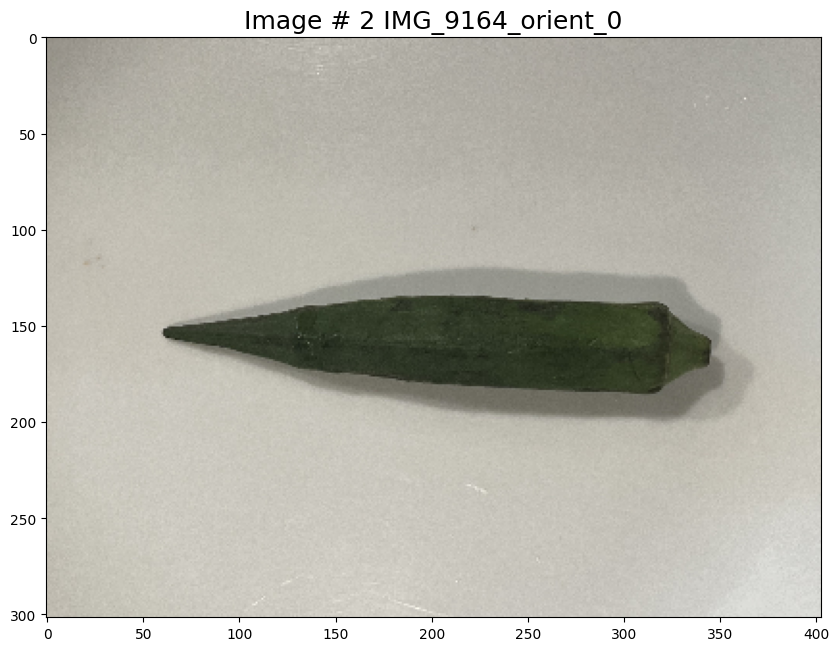

In [34]:
img_nparray = img_tensor.permute(1, 2, 0).numpy()
print("image shape after permute ", img_nparray.shape)

neg_mask = ~mask

print("images.shape = ", type(img_tensor) , img_tensor.dtype , img_tensor.shape)
print("true_masks.shape = ", type(mask), mask.dtype, mask.shape)

plt.figure(figsize=(10,10))
img_name = dataset.ids[iter_cnt - 1]
plt.title(f"Image # {iter_cnt} {img_name}", fontsize=18)
plt.imshow(img_nparray)

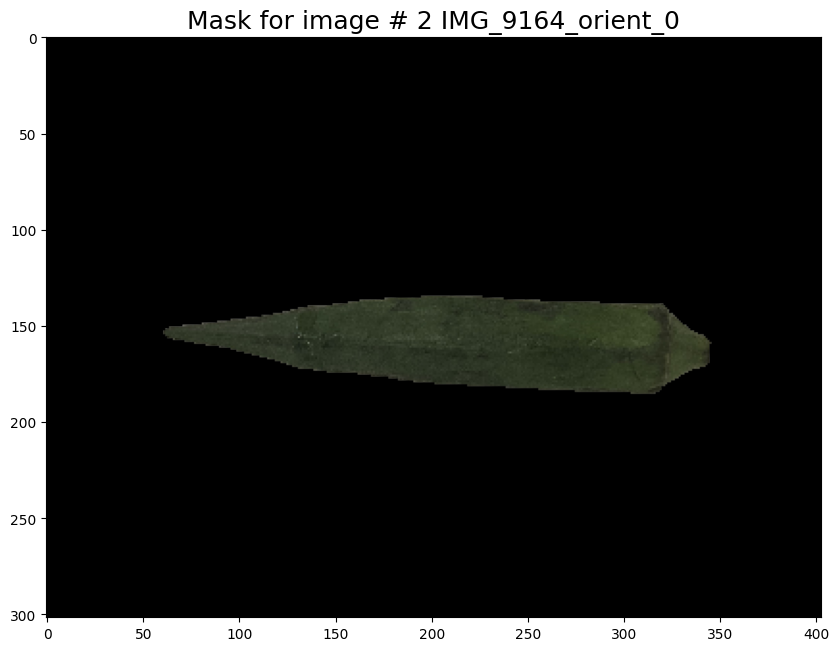

In [35]:
show_image_with_mask(img_nparray, neg_mask, iter_cnt, img_name)

In [20]:
print(type(image), image.dtype, image.shape)
#print("value of R at (150,200) = ", image[0][0][150][200])
#print("value of G at (150,200) = ", image[0][1][150][200])
#print("value of B at (150,200) = ", image[0][1][150][200])
print(image[0,0,:,200])

<class 'torch.Tensor'> torch.float32 torch.Size([1, 3, 302, 403])
tensor([0.8157, 0.8588, 0.7882, 0.7765, 0.7961, 0.8000, 0.8078, 0.7922, 0.8078,
        0.8039, 0.7961, 0.7843, 0.8275, 0.8078, 0.8353, 0.8039, 0.7882, 0.7961,
        0.8392, 0.8078, 0.7804, 0.8196, 0.8118, 0.8078, 0.7843, 0.8314, 0.7922,
        0.8275, 0.7922, 0.8118, 0.7922, 0.8078, 0.8000, 0.8078, 0.7882, 0.7922,
        0.8000, 0.8039, 0.7922, 0.8039, 0.8275, 0.7922, 0.7922, 0.7961, 0.7882,
        0.8039, 0.7882, 0.8118, 0.7882, 0.8078, 0.7843, 0.7922, 0.8157, 0.8157,
        0.8078, 0.7961, 0.8078, 0.7961, 0.7882, 0.7882, 0.8235, 0.8000, 0.8039,
        0.8157, 0.7882, 0.7882, 0.7843, 0.8000, 0.8039, 0.8078, 0.7961, 0.7961,
        0.7922, 0.7922, 0.7922, 0.7961, 0.8039, 0.8000, 0.7882, 0.8000, 0.7922,
        0.7961, 0.8000, 0.7882, 0.7961, 0.7961, 0.8000, 0.8078, 0.8000, 0.8039,
        0.8078, 0.8078, 0.8039, 0.8039, 0.7961, 0.7961, 0.8039, 0.8118, 0.8000,
        0.8196, 0.8039, 0.8039, 0.7961, 0.7961, 0.8039

In [38]:
# model.eval()

# mask_pred = model(image)['out'].detach()
d0, d1, d2, d3, d4, d5, d6 = model(image)
mask_pred =  d0.squeeze(1)
print(mask_pred.shape)
#print(mask_pred.dtype)
print(mask_pred)

torch.Size([1, 302, 403])
tensor([[[1.8098e-03, 1.0318e-03, 7.1813e-04,  ..., 1.9265e-04,
          2.7892e-04, 4.9689e-04],
         [1.5808e-03, 8.9197e-04, 6.5353e-04,  ..., 1.9509e-04,
          2.6386e-04, 4.4471e-04],
         [1.4001e-03, 8.1929e-04, 6.3972e-04,  ..., 1.6363e-04,
          2.2447e-04, 3.8842e-04],
         ...,
         [1.0616e-03, 6.7856e-04, 4.9539e-04,  ..., 2.3092e-05,
          4.2182e-05, 1.3029e-04],
         [1.1789e-03, 7.3510e-04, 5.4038e-04,  ..., 2.1885e-05,
          4.2254e-05, 1.4299e-04],
         [1.2765e-03, 7.4259e-04, 5.0025e-04,  ..., 3.5898e-05,
          6.8932e-05, 2.0189e-04]]], grad_fn=<SqueezeBackward1>)


code/__torch__/torch/nn/functional/___torch_mangle_78.py:8: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.


torch.Size([1, 3, 302, 403])


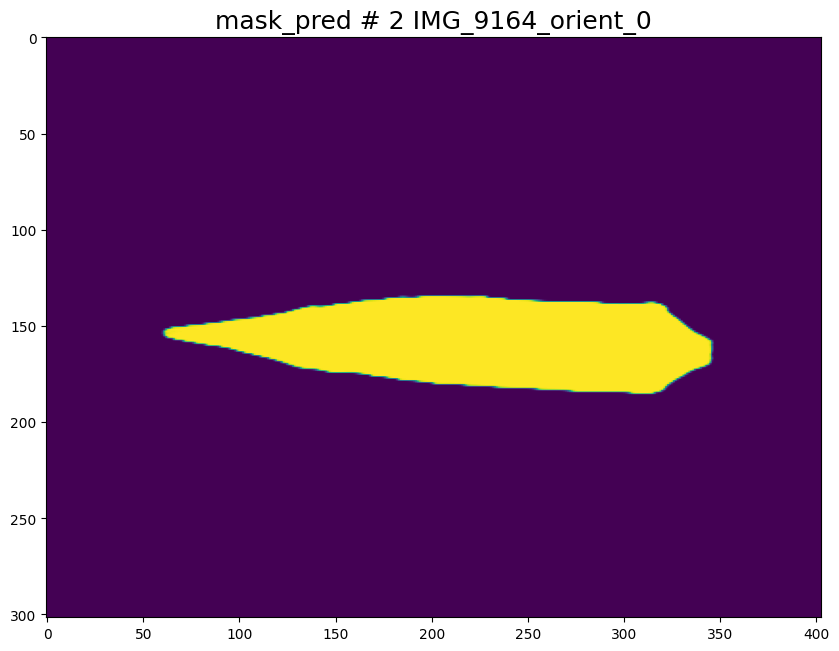

In [37]:
# torch.save({'model_state_dict': model.state_dict()}, '.ipynb_checkpoints/checkpoint_weights.pt')

#print(2)
#print("max value = ", torch.max(mask_pred))
#print("min value = ", torch.min(mask_pred))
#print("mask_pred shape = ", mask_pred.shape)
#print(mask_pred[0,0,:,200])

print(image.shape)
#print(mask_pred.shape)

im2 = mask_pred.detach()
#im2[1] = torch.masked_select(image[0][1], mask_pred)
#im2[2] = torch.masked_select(image[0][2], mask_pred)
img2_tensor = im2.squeeze(0)
img2_nparray = img2_tensor.numpy()
#img2_nparray = img2_tensor.permute(1, 2, 0).numpy()
#img2_tensor = im2.squeeze()
#img2_nparray = img2_tensor.numpy()
plt.figure(figsize=(10,10))
img_name = dataset.ids[iter_cnt - 1]
plt.title(f"mask_pred # {iter_cnt} {img_name}", fontsize=18)
plt.imshow(img2_nparray)

In [ ]:
# this doesnt work with mobilenet

#traceable_model = model.eval()
#trace = torch.jit.trace(traceable_model, image)

#mlmodel = ct.convert(
#    trace,
#    inputs=[ct.TensorType(name="input", shape=image.shape)],
#)

torch.float32


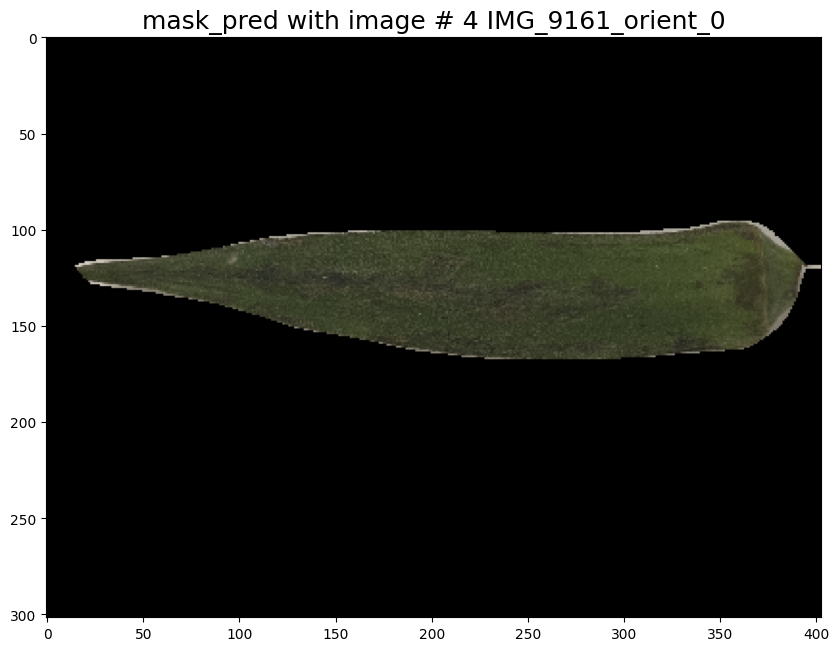

In [ ]:
print(mask_pred.dtype)
mask_pred = (mask_pred >= 0.5)
im2 = image * mask_pred
#im2[1] = torch.masked_select(image[0][1], mask_pred)
#im2[2] = torch.masked_select(image[0][2], mask_pred)
img2_tensor = im2.squeeze(0)
img2_nparray = img2_tensor.permute(1, 2, 0).numpy()
plt.figure(figsize=(10,10))
img_name = dataset.ids[iter_cnt - 1]
plt.title(f"mask_pred with image # {iter_cnt} {img_name}", fontsize=18)
plt.imshow(img2_nparray)

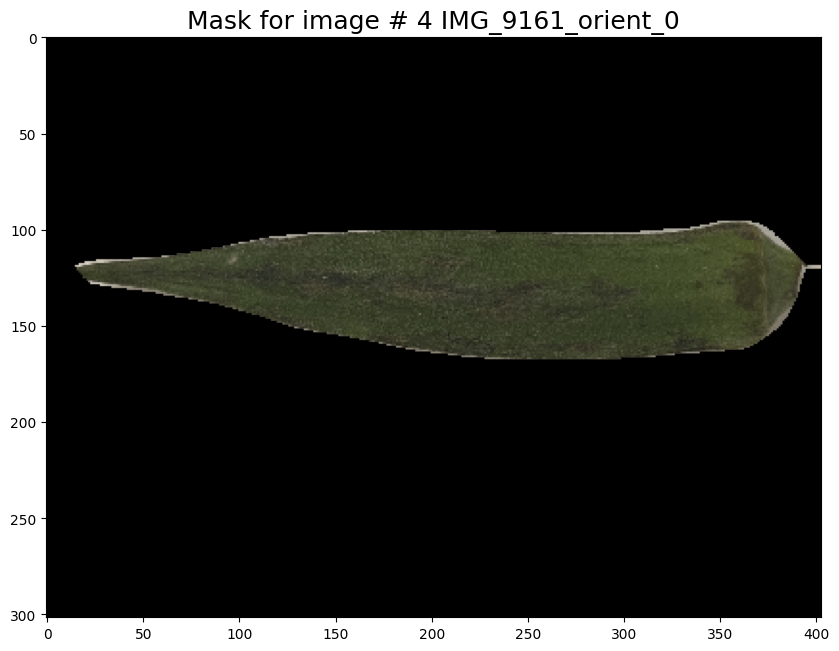

In [ ]:
show_image_with_mask(img_nparray, ~mask_pred, iter_cnt, img_name)